# Objectives of this notebook and discussion

As we now have a better understanding of the data, we will proceed to create a model to predict the games of season 2. We will train a Poisson regression model using only season 1 data. Two models will be created: one for home predictions and one for away predictions. This way, each model can capture any potential advantage of playing at home, which is typically expected.

We will first generate features based on the attacking and defensive performances of every team throughout the season. Additionally, we will include the rating of the goalkeepers for each game in the model's input, that way the model will also incorporate a feature related to the starting XI.

Since we cannot predict the starting XI for the next season, we will randomly sample the goalkeeper for both teams for each game. We have a dataset that includes all goalkeepers per team, along with their adjusted ratings from the previous season.

By doing this, we will be able to generate confidence intervals for our predictions.

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import poisson
from scipy import stats
from sklearn.preprocessing import StandardScaler
import numpy as np, scipy.stats as st

In [2]:
## Get the current working directory
current_directory = os.getcwd()
## Use a global variable for the path to the data
FILES_PATH = f"{current_directory}/data/"

MODEL_FEATURES_HOME = [
    "HomeScore",
    "in_HomeSeasonShotsAvg", 
    "in_AwaySeasonShotsConcededAvg",
    "in_HomeAttackStrength", 
    # "in_HomeDefenceStrength",
    # "in_HomeGoalkeeperAdjustedRating",
    # "in_HomeStrengthDifference",
    # "in_AwayAttackStrength",
    "in_AwayDefenceStrength",
    "in_HomeShotsAccuracy"
    ]

MODEL_FEATURES_AWAY = [
    "AwayScore",
    "in_AwaySeasonShotsAvg", 
    "in_HomeSeasonShotsConcededAvg",
    "in_AwayAttackStrength", 
    "in_HomeDefenceStrength",
    # "in_AwayGoalkeeperAdjustedRating",
    # "in_AwayStrengthDifference",
    # "in_HomeAttackStrength",
    "in_HomeDefenceStrength",
    "in_AwayShotsAccuracy"
    ]

In [3]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")
goalkeeper_games = pd.read_parquet(f"{FILES_PATH}goalkeeper_games.pq")
goalkeeper_teams = pd.read_parquet(f"{FILES_PATH}goalkeeper_teams.pq")

## Creation of a class to preprocess the data in order to generate inputs for the model

In [4]:
class DataPreprocessing: 
    @staticmethod
    def players_stats_preprocessing(df_gk_games : pd.DataFrame, df_gk_teams : pd.DataFrame) -> list[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """ 
        Preprocess the goalkeeper scores datasets and make them a parent class variables so it can be used in the model pipeline.
        """
        goalkeeper_games_home = df_gk_games.copy()
        goalkeeper_games_away= df_gk_games.copy()

        goalkeeper_games_home = goalkeeper_games_home.rename(columns = {"TeamID" : "HomeTeamID",
                                                                        "GoalkeeperAdjustedRating" : "in_HomeGoalkeeperAdjustedRating",
                                                                        "PlayerID" : "HomePlayerID",
                                                                        "PositionID" : "HomePositionID"
                                                                        })
        goalkeeper_games_away = goalkeeper_games_away.rename(columns = {"TeamID" : "AwayTeamID",
                                                                        "GoalkeeperAdjustedRating" : "in_AwayGoalkeeperAdjustedRating",
                                                                        "PlayerID" : "AwayPlayerID",
                                                                        "PositionID" : "AwayPositionID"
                                                                        })
        goalkeeper_teams = df_gk_teams.rename(columns = {"GoalkeeperAdjustedRating" : "in_GoalkeeperAdjustedRating"})
        return goalkeeper_games_home, goalkeeper_games_away, goalkeeper_teams
    
    goalkeeper_games_home, goalkeeper_games_away, goalkeeper_teams = players_stats_preprocessing(goalkeeper_games, goalkeeper_teams) 

    def game_outcome_ground_truth(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Encode the results of the game.
        - 0 if Home Team won
        - 1 if a draw
        - 2 if Away Team won 
        """
        df["GameOutcome"] = 0 
        df.loc[df["HomeScore"] == df["AwayScore"], "GameOutcome"] = 1  
        df.loc[df["HomeScore"] < df["AwayScore"], "GameOutcome"] = 2
        return df
    
    
    def season_split(self, df : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split the results dataset into two dataframes for season 1 & 2 
        """
        results_data_season1 = df.copy()
        results_data_season2 = df.copy()
        results_data_season1 = results_data_season1[results_data_season1["SeasonID"]==1]
        results_data_season2 = results_data_season2[results_data_season2["SeasonID"]==2]
        return results_data_season1, results_data_season2

    def split_input_output(self, df : pd.DataFrame, home_boolean : bool) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Generate the model input dataset as well as the ground truth - here the number of goals.  
        """
        if home_boolean:
            y = df[["HomeScore"]]
            X = df[MODEL_FEATURES_HOME].drop(columns = ["HomeScore"])
            
        else:
            y = df[["AwayScore"]]
            X = df[MODEL_FEATURES_AWAY].drop(columns = ["AwayScore"])
        return X, y
    
    def select_input_features(self, df : pd.DataFrame, home_boolean : bool) -> pd.DataFrame:
        """
        Return a dataset used for training the model only with the relevant features. 
        """
        if home_boolean:
            return df[MODEL_FEATURES_HOME]
        else:
            return df[MODEL_FEATURES_AWAY]

    
    def merge_results_stats(self, results_df : pd.DataFrame, stats_df : pd.DataFrame, _home_boolean : bool) -> pd.DataFrame:
        """
        Add the new features to the existing results dataset. 
        """
        if _home_boolean:
            results_df = results_df.merge(stats_df, on = ["HomeTeamID"], how = "left")
        else:
            results_df = results_df.merge(stats_df, on = ["AwayTeamID"], how = "left")
        return results_df
    
    def normalised_data(self, df : pd.DataFrame, trained_scaler) -> pd.DataFrame:
        """ 
        Normalise the data using the Standard Scaler method.
        """
        if trained_scaler is None:
            scaler = StandardScaler()
            df_scaled = scaler.fit_transform(df)
            return pd.DataFrame(df_scaled, columns = df.columns), scaler
        else:
            df_scaled = trained_scaler.transform(df)
            return pd.DataFrame(df_scaled, columns = df.columns)
        

Encode the outcome of the game in the results dataset
- 0 if Home Team won
- 1 if a draw
- 2 if Away Team won 

In [5]:
data_preprocessing = DataPreprocessing()
results_data = data_preprocessing.game_outcome_ground_truth(results_data)

We extract the unique id of each team and make it a global list as it can be useful throughout the model implementation.

In [6]:
ALL_TEAM_IDS = results_data["HomeTeamID"].sort_values().unique().tolist()

Split dataset into a train dataset for season 1 and a test dataset for season 2

In [7]:
results_data_season1, results_data_season2 = data_preprocessing.season_split(results_data)

## Feature engineering on the season 1 data

The following features have been created for the home model. They are similar for the away model, only _home_ and _away_ are inverted.
- Average number of shots taken by the home team per game
- Average number of shots conceded by the away team per game
- $$\text{Attack strength of the home team} = \frac{\text{Average number of goals scored at home by the home team per game}}{\text{Average number of goals scored at home in season 1}}$$
- $$\text{Defence strength of the away team} = \frac{\text{Average number of away goals conceded by the away team per game}}{\text{Average number of away goals conceded in season 1}}$$
<!-- - The difference between the attack strength of the home team and the defence strength of the away team -->
- $$\text{Defence strength of the away team} = \frac{\text{Average number of away goals conceded by the team per game}}{\text{Average number of away goals conceded in season 1}}$$
- $$\text{Shot accuracy} = \frac{\text{Total number of goals scored at home}}{\text{Total number of shots taken at home}}
- Goalkeeper's adjusted rating

In [8]:
class FeatureEngineering(DataPreprocessing):
    def __init__(self):
        """
        We generate variables that wil be used throughout the training of the model.
        - The results datasets for season 1 and season 2.

        We generate general statistics about the first season that will be used throughout the model training and testing. 
        - Calcualtion of the total number of goals scored at home/away. 
        - Calculation of the average number of goals scored at home/away. 
        """
        self.results_data_season1, self.results_data_season2 = self.season_split(results_data)
        self.total_league_goals_home, self.total_league_goals_away, self.average_league_goals_home, self.average_league_goals_away = self.season_statistics(self.results_data_season1)
        

    def season_statistics(self, df : pd.DataFrame) -> list[int, int, float, float]:
        """
        Calculate the total number of goals scored at home/away. 
        As well the average number of goals scored at home/away. 
        """
        return df.HomeScore.sum(), df.AwayScore.sum(), df.HomeScore.mean(), df.AwayScore.mean()
    
    def generate_average_stats_home(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Calculate the average number of goals scored/conceded for every home team. 
        """
        ## Sum and average shots and goals per game for the home team
        df = df.groupby(["HomeTeamID"]).agg(
            in_HomeSeasonGoalsSum = ("HomeScore", "sum"),
            in_HomeSeasonShotsSum = ("HomeShots", "sum"),
            in_HomeSeasonGoalsScoredAvg = ("HomeScore", "mean"),
            in_HomeSeasonGoalsConcededAvg = ("AwayScore", "mean"),
            in_HomeSeasonShotsAvg = ("HomeShots", "mean"),
            in_HomeSeasonShotsConcededAvg = ("AwayShots", "mean")
            ).reset_index()

        ## Calculation of the shot accuracy for the home team
        df["in_HomeShotsAccuracy"] = df["in_HomeSeasonGoalsSum"]/df["in_HomeSeasonShotsSum"]
        return df
    

    def generate_average_stats_away(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Calculate the average number of goals scored/conceded for every away team.  
        """
        ## Sum and average shots and goals per game for the away team
        df = df.groupby(["AwayTeamID"]).agg(
        in_AwaySeasonGoalsSum = ("AwayScore", "sum"),
        in_AwaySeasonShotsSum = ("AwayShots", "sum"),
        in_AwaySeasonGoalsScoredAvg = ("AwayScore", "mean"),
        in_AwaySeasonGoalsConcededAvg = ("HomeScore", "mean"),
        in_AwaySeasonShotsAvg = ("AwayShots", "mean"),
        in_AwaySeasonShotsConcededAvg = ("HomeShots", "mean")
        ).reset_index()
        
        ## Calculation of the shot accuracy for the away team
        df["in_AwayShotsAccuracy"] = df["in_AwaySeasonGoalsSum"]/df["in_AwaySeasonShotsSum"]
        return df

    def calculate_strength_home(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Divide the average number of goals scored by a home team by the average number of home goals scored thoughout the season.
        """
        df["in_HomeAttackStrength"] = df["in_HomeSeasonGoalsScoredAvg"]/self.average_league_goals_home
        df["in_HomeDefenceStrength"] = df["in_HomeSeasonGoalsConcededAvg"]/self.average_league_goals_away
        return df.drop(columns=["in_HomeSeasonGoalsScoredAvg", "in_HomeSeasonGoalsConcededAvg"])

    def calculate_strength_away(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Divide the average number of goals scored by an away team by the average number of away goals scored thoughout the season.
        """
        df["in_AwayAttackStrength"] = df["in_AwaySeasonGoalsScoredAvg"]/self.average_league_goals_away
        df["in_AwayDefenceStrength"] = df["in_AwaySeasonGoalsConcededAvg"]/self.average_league_goals_home
        return df.drop(columns=["in_AwaySeasonGoalsScoredAvg", "in_AwaySeasonGoalsConcededAvg"])
    
    def generate_features_dataset(self, df : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Calculate the the average attack & defence strenght scores for every team.
        """
        df_features_home = self.generate_average_stats_home(df)
        df_features_away = self.generate_average_stats_away(df)
        df_features_home = self.calculate_strength_home(df_features_home)
        df_features_away = self.calculate_strength_away(df_features_away)

        # df_features_home["in_HomeStrengthDifference"] = df_features_home["in_HomeAttackStrength"] - df_features_home["in_AwayDefenceStrength"]
        # df_features_away["in_AwayStrengthDifference"] = df_features_away["in_AwayAttackStrength"] - df_features_away["in_HomeDefenceStrength"]

        return df_features_home, df_features_away
    
    def add_home_away_features(self, df_results : pd.DataFrame, df_features_home : pd.DataFrame, df_features_away : pd.DataFrame) -> pd.DataFrame:
        """
        Merge the results of season 1 with the team features previously calculated. 
        """
        df_merged = df_results.merge(df_features_home, on = ["HomeTeamID"], how = "left")
        df_merged = df_merged.merge(df_features_away, on = ["AwayTeamID"], how = "left")
        
        # df_merged["in_HomeStrengthDifference"] = df_merged["in_HomeAttackStrength"] - df_merged["in_AwayDefenceStrength"]
        # df_merged["in_AwayStrengthDifference"] = df_merged["in_AwayAttackStrength"] - df_merged["in_HomeDefenceStrength"]
        return df_merged

    
    def add_goalkeeper_rating_feature(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Add the goalkeeper ratings to the train results dataset for home and away teams.  
        """
        df_merged = df.merge(FeatureEngineering.goalkeeper_games_home, on = ["MatchID", "HomeTeamID"], how = "left")
        return df_merged.merge(FeatureEngineering.goalkeeper_games_away, on = ["MatchID", "AwayTeamID"], how = "left")

In [9]:
feature_engineering = FeatureEngineering()

### Team-oriented statistics
- Calculation of attack & defence strengths for home & away teams
- Shots and goals conceded features generation

In [10]:
## Generate features for every team home and away
df_features_home, df_features_away = feature_engineering.generate_features_dataset(results_data_season1)

## Add the features to the original results dataset
train_results_merged = feature_engineering.add_home_away_features(results_data_season1, df_features_home, df_features_away)

## Add the goalkeeper feature to the train dataset
train_results_merged = feature_engineering.add_goalkeeper_rating_feature(train_results_merged)

## Creation of a class to train the Poisson regression model

In [11]:
class TrainModel(DataPreprocessing):    
    def model_training(self, X : pd.DataFrame, y : pd.DataFrame):
        """
        Fit a Poisson regression model to the train data. 
        """
        return sm.GLM(y, X, family=sm.families.Poisson()).fit()
    
    def run_model_training(self, df : pd.DataFrame):
        ## Generate the model inputs and ground truths for home & away team
        train_features_home = self.select_input_features(df, home_boolean = True)
        train_features_away = self.select_input_features(df, home_boolean = False)

        ## Normalise the data
        train_features_scaled_home, scaler_home = self.normalised_data(train_features_home, None)
        train_features_scaled_away, scaler_away = self.normalised_data(train_features_away, None)

        ## Generate model inputs and outputs
        X_home, y_home = self.split_input_output(train_features_scaled_home, home_boolean = True)
        X_away, y_away = self.split_input_output(train_features_scaled_away, home_boolean = False)

        ## - Build a Poisson regression model to generate predicitons for team playing at home
        ## - Build another model for team playing away 
        model_home = self.model_training(X_home, y_home)
        model_away = self.model_training(X_away, y_away)
        return model_home, model_away, scaler_home, scaler_away, X_home, X_away

- Training of two models: home and away results.
- We also normalise the data using a Standard Scaler method, so we do return the scalers fitted on the home and away data
- The function returns the input datasets for home and away games

In [12]:
train_model = TrainModel()
model_home, model_away, scaler_home, scaler_away, X_home, X_away = train_model.run_model_training(train_results_merged)

## Creation of a class to test the model

In [13]:
class TestModel(FeatureEngineering):
    def predict_expected_value_goal(self, model, X : pd.Series) -> np.array:
        """
        Predict the expected value of the poisson distribution for a fixture and a team. 
        """
        return model.predict(X.values.tolist())
    
    def random_draw_goal_distrib(self, predicted_lambda : np.array, n : int = 10000) -> np.array:
        """
        Draw samples from a Poisson distribution given its expected value. 
        """
        return np.random.poisson(lam=predicted_lambda, size=(n, len(predicted_lambda))).flatten()
    
    def count_goals(self, simulated_goals : np.array, home_boolean : bool) -> pd.Series:
        """
        Calculate the probability for a set of goals to be scored for a certain fixture. 
        """
        if home_boolean:
            return simulated_goals.value_counts().sort_index().rename("HomeGoalsProbability")/len(simulated_goals)
        else:
            return simulated_goals.value_counts().sort_index().rename("AwayGoalsProbability")/len(simulated_goals)
        
    def generate_goals_proba_table(self,home_goals_proba : pd.Series, away_goals_proba : pd.Series) -> pd.DataFrame:
        """
        Concatenate the goal probabilities for home and away team. 
        """
        return pd.concat([home_goals_proba, away_goals_proba], axis = 1).sort_index().fillna(0)
    
    def calculate_scores_proba(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Multiply the probability of Home Team to score X goals with the probability of Away Team to score Y goals.
        Return a matrix containing the probability of every possible outcome (e.g.: 0-1, 2-2, etc.) 
        """
        scores_proba_matrix = np.outer(df["HomeGoalsProbability"].values, df["AwayGoalsProbability"].values)
        return pd.DataFrame(scores_proba_matrix, index = df.index, columns = df.index)
    
    def calculate_outcome_probability(self, df : pd.DataFrame) -> list[float, float, float]:
        """
        Calculate the probability for the home/away team to win, draw or lose.
        Given the matrix containing the every outcome probability, it sums the all the probabilities for:
        - Home Team to win
        - Away Team to win
        - Draw
        """
        probability_home_win = 0
        probability_away_win = 0
        probability_draw = 0
        for i in range(len(df)):
            for j in range(len(df)):
                if i==j:
                    probability_draw += df.iloc[i, j]
                elif i<j:
                    probability_away_win += df.iloc[i, j]
                else:
                    probability_home_win += df.iloc[i, j]
        return probability_home_win, probability_draw, probability_away_win
    
    def game_outcome(self, probability_win_home : float, probability_draw : float, probability_win_away : float) -> int:
        """
        Find the result with the highest probability and return it as the game outcome.  
        """
        return np.argmax([probability_win_home, probability_draw, probability_win_away])
    
    def generate_input_testing(self, df : pd.DataFrame, df_features_home : pd.DataFrame, df_features_away : pd.DataFrame) -> pd.DataFrame:
        """
        Generate inputs for testing. 
        """
        test_results_home = df.merge(df_features_home, on = "HomeTeamID", how = "left")
        test_results_away = df.merge(df_features_away, on = "AwayTeamID", how = "left")
        X_test_home, _ = self.split_input_output(test_results_home, home_boolean=True)
        X_test_away, _ = self.split_input_output(test_results_away, home_boolean=False)

        return X_test_home, X_test_away
    
    def random_goalkeeper_selection(self, n_draw : int = 1) -> pd.DataFrame:
        return TestModel.goalkeeper_teams.groupby(["TeamID"]).apply(lambda x: x.sample(n=n_draw))[["TeamID", "in_GoalkeeperAdjustedRating"]].reset_index(drop=True)
    
    def merge_random_players_results(self, df_results : pd.DataFrame, df_gk : pd.DataFrame) -> pd.DataFrame:
        """
        Merge the goalkeeper selected at random for every team with the results of season 2. 
        """
        df_gk_home = df_gk.rename(columns = {"in_GoalkeeperAdjustedRating" : "in_HomeGoalkeeperAdjustedRating"})
        df_gk_away = df_gk.rename(columns = {"in_GoalkeeperAdjustedRating" : "in_AwayGoalkeeperAdjustedRating"})

        df_merged = df_results.merge(df_gk_home, left_on = ["HomeTeamID"], right_on = ["TeamID"], how = "left").drop(columns = ["TeamID"])
        return df_merged.merge(df_gk_away, left_on = ["AwayTeamID"], right_on = ["TeamID"], how = "left").drop(columns = ["TeamID"])
    
    def run_model_testing(self, df : pd.DataFrame, df_features_home : pd.DataFrame, df_features_away : pd.DataFrame, scaler_home : pd.DataFrame, scaler_away : pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        test_results_merged = self.add_home_away_features(df, df_features_home, df_features_away)
        goalkeeper_random_selection = self.random_goalkeeper_selection(n_draw = 1)
        test_results_merged = self.merge_random_players_results(test_results_merged, goalkeeper_random_selection)

        test_features_home = train_model.select_input_features(test_results_merged, home_boolean = True)
        test_features_away = train_model.select_input_features(test_results_merged, home_boolean = False)
        
        test_features_scaled_home = self.normalised_data(test_features_home, scaler_home)
        test_features_scaled_away = self.normalised_data(test_features_away, scaler_away)

        X_test_home, _ = self.split_input_output(test_features_scaled_home, home_boolean=True)
        X_test_away, _ = self.split_input_output(test_features_scaled_away, home_boolean=False)
        return X_test_home, X_test_away
    
    def model_testing_metrics_generation(self, X_test_home, X_test_away, model_home, model_away):
        probability_win_home_test = []
        probability_draw_test = []
        probability_win_away_test = []
        game_outcome_test = []
        for i in range(len(X_test_home)):
            X_test_home_i = X_test_home.iloc[i]
            X_test_away_i = X_test_away.iloc[i]

            predicted_lambda_home = self.predict_expected_value_goal(model_home, X_test_home_i)
            predicted_lambda_away = self.predict_expected_value_goal(model_away, X_test_away_i)

            simulated_goals_home = self.random_draw_goal_distrib(predicted_lambda_home)
            simulated_goals_away = self.random_draw_goal_distrib(predicted_lambda_away)

            home_goals_proba = self.count_goals(pd.Series(simulated_goals_home), home_boolean = True)
            away_goals_proba = self.count_goals(pd.Series(simulated_goals_away), home_boolean = False)
            goals_proba_matrix = self.generate_goals_proba_table(home_goals_proba, away_goals_proba)
                    
            scores_proba_df = self.calculate_scores_proba(goals_proba_matrix)
            probability_win_home, probability_draw, probability_win_away  = self.calculate_outcome_probability(scores_proba_df)

            probability_win_home_test.append(probability_win_home)
            probability_draw_test.append(probability_draw)
            probability_win_away_test.append(probability_win_away)
            game_outcome_test.append(self.game_outcome(probability_win_home, probability_draw, probability_win_away))

        return pd.DataFrame({
        "HomeTeamWinProbability" : probability_win_home_test,
        "TeamsDrawProbability" : probability_draw_test,
        "AwayTeamWinProbability" : probability_win_away_test,
        "PredictedGameOutcome" : game_outcome_test
        })
    
    def merge_season2_outcomes(self, df_season : pd.DataFrame, df_results : pd.DataFrame) -> pd.DataFrame:
        """
        Concatenate the predictions of win/draw/lose with the original dataset for season 2.
        """
        return pd.concat([df_season.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
    

    def compile_test_results(self, df_season2 : pd.DataFrame, df_features_home : pd.DataFrame, df_features_away : pd.DataFrame, scaler_home : pd.DataFrame, scaler_away : pd.DataFrame) -> pd.DataFrame:
        """
        Run the test pipeline and compile results into a dataset that will be used later for analysis purposes. 
        """
        ## Run the testing pipeline to evaluate the model
        X_test_home, X_test_away = self.run_model_testing(df_season2, df_features_home, df_features_away, scaler_home, scaler_away)

        ## Compute metrics to evaluate the model
        model_test_outcomes = self.model_testing_metrics_generation(X_test_home, X_test_away, model_home, model_away)

        ## Merge the predicted outcomes with the existing data
        test_results_prediction = self.merge_season2_outcomes(df_season2, model_test_outcomes)
        
        return test_results_prediction


- We run the test pipeline and compute the predicted outcomes in a dataframe that will be used in the next part.
- Everytime the compile function is ran, a random selection of goalkeepers is made for every game of the season.
- It then includes some randomness in the data that will be then used to generate confidence interval.

In [14]:
test_model = TestModel()
test_results_prediction = test_model.compile_test_results(results_data_season2, df_features_home, df_features_away, scaler_home, scaler_away)
test_results_prediction.head()

/tmp/ipykernel_25373/2174078406.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return TestModel.goalkeeper_teams.groupby(["TeamID"]).apply(lambda x: x.sample(n=n_draw))[["TeamID", "in_GoalkeeperAdjustedRating"]].reset_index(drop=True)


,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,GameOutcome,HomeTeamWinProbability,TeamsDrawProbability,AwayTeamWinProbability,PredictedGameOutcome
0,2,1,757,2,1,14,1,2,16,2,0.135863,0.280617,0.583520,2
1,2,1,758,28,5,25,3,1,7,0,0.342143,0.330765,0.327092,0
2,2,1,759,27,0,7,4,1,15,2,0.190112,0.251927,0.557961,2
3,2,1,760,26,2,7,5,6,27,2,0.066018,0.166875,0.767106,2
4,2,1,761,25,0,6,6,3,17,2,0.040723,0.126510,0.832766,2


We now have:
$$P(X = \text{Home Team Win} | \text{Fixture}_i)$$
$$P(X = \text{Draw} | \text{Fixture}_i)$$
$$P(X = \text{Away Team Win} | \text{Fixture}_i)$$

In [15]:
# test_results_prediction["PredictedGameOutcome"].value_counts()

<!-- ### Monte-Carlo simualtion using the outcome probabilities to compute the final ranking probabilities of season 2 -->

We employ Monte Carlo simulations to predict the outcomes of all games in Season 2, leveraging the probabilities generated by the model: $$P(X = \text{Home Team Win} | \text{Fixture}_i), P(X = \text{Draw} | \text{Fixture}_i), P(X = \text{Away Team Win} | \text{Fixture}_i)$$

In [16]:
class MonteCarloSimulation(TestModel):
    def MC_simulation_single_season(self, df : pd.DataFrame) -> pd.DataFrame:
        """
        Returns the total number of points for every team after simulating
        the whole season given the probabilities calculated by the model.
        """
        points = {_team: 0 for _team in ALL_TEAM_IDS}
        for i in range(len(df)):
            _game = df.iloc[i]
            
            team_id_home = _game["HomeTeamID"] ## Home Team ID
            team_id_away = _game["AwayTeamID"] ## Away Team ID

            proba_win_home = _game["HomeTeamWinProbability"] ## Probability of Home Team to win that game
            proba_draw = _game["TeamsDrawProbability"] ## Probability of teams to draw
            proba_win_away = _game["AwayTeamWinProbability"] ## Probability of Away Team to win that game

            ## Generation of a random number {0, 1, 2} with the probabilities of [Home, Draw, Away]
            _outcome = np.random.choice(np.arange(0, 3), p=[proba_win_home, proba_draw, proba_win_away])

            ## 3, 1 or 0 points are then added to the team's total points of the season
            if _outcome == 0:
                points[team_id_home] += 3 
            elif _outcome == 1:
                points[team_id_home] += 1
                points[team_id_away] += 3 
            else:
                points[team_id_away] += 3 
        return points
    
    def MC_simulation_multiple_seasons(self, df : pd.DataFrame, n_iterations : int = 100) -> pd.DataFrame:
        """
        Simulate a number of n_iterations seasons using the probabilities of the model.
        It returns the probability of every ranking for every team.  
        """
        position_counts = {_team: [0] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS} ## Dictionnary containing the history of every team's ranking
        for _iter in range(n_iterations):
            season_points = self.MC_simulation_single_season(df) ## Simulation of a single season

            ## We save the points in a dataframe and ranked the teams accordingly
            df_season_points = pd.DataFrame(season_points.items(), columns = ["TeamID", "SeasonPoints"])\
                .sort_values(by = ["SeasonPoints"], ascending=False)\
                    .reset_index(drop=True)
            
            ## The ranking of every team for this season is saved in a dictionnary
            for _pos, team_val in df_season_points.iterrows():
                team_id = team_val["TeamID"]
                position_counts[team_id][_pos] += 1

        ## Generation of ranking probabilities by dividing the number of times a team finishes in a specific position by the total number of simulations
        for _key, _val in position_counts.items():
            position_counts[_key] = [x/n_iterations for x in _val]

        ## Creation of a dataframe for the results with the ranking as index and the teams as columns
        df_positions = self.transform_dict_to_dataframe(position_counts)
        return position_counts, df_positions
    
    def transform_dict_to_dataframe(self, dict_val : dict) -> pd.DataFrame:
        """
        Transform dictionnary containing the ranking probabilities into a dataframe. 
        Creation of a dataframe for the results with the ranking as index and the teams as columns
        """
        df = pd.DataFrame(dict_val, index = dict_val.keys())
        df.columns = [f"TeamID_{x}" for x in df.columns]
        return df

    def run_multiple_MC_different_goalkeeper(self, df_results : pd.DataFrame, df_features_home : pd.DataFrame, df_features_away : pd.DataFrame, scaler_home : pd.DataFrame, scaler_away, n_iter_CI : int = 10, n_iter_MC : int = 100) -> dict:
        """
        Run the test pipeline n_iter times:
        - Everytime a goalkeeper is randomly assigned to their team for a specific fixture
        - n_iter_MC Monte-Carlo simulations are run returning the probabilities of every ranking for every team
        - The outcomes are saved in a dictionnary for further manipulations
        - The number of runs is: n_iter_CI * n_iter_MC 
        """
        ## Creation of the dictionnary to save outcomes
        total_position_counts = {_team: [] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS}

        ## Run the test and the Monte-Carlo pipeline n_iter_CI times
        for i in range(n_iter_CI):
            ## Draw goalkeepers at random and generate probabilities
            test_results_prediction = self.compile_test_results(df_results, df_features_home, df_features_away, scaler_home, scaler_away)

            ## Run Monte-Carlo simualtions and generate season ranking probabilites
            position_counts_season2, _ = self.MC_simulation_multiple_seasons(df = test_results_prediction, n_iterations = n_iter_MC)

            ## Save the outcomes in the dictionnary
            for j in total_position_counts.keys():
                total_position_counts[j].append(position_counts_season2[j])
        return total_position_counts
    
    def confidence_intervals_calculation(self, total_position_counts : dict, confidence_interval_coeff : float = 0.95) -> list[dict, dict, dict]:
        """
        Take as an input the results of the multiple Monte-Carlo simualtions with a random goalkeeper assignment everytime. 
        Calculate the confidence intervals for a team to finish at every ranks at the end of the season as 
        we have multiple season simulations with different goalkeepers for every game. 
        """
        ## Creation of the dictionnaries to save the confidence intervals as well as the mean
        total_position_lower_CI = {_team: [0] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS}
        total_position_upper_CI = {_team: [0] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS}
        total_position_mean = {_team: [0] * len(ALL_TEAM_IDS) for _team in ALL_TEAM_IDS}

        ## Iteration for every team
        for team_iter in range(1, len(ALL_TEAM_IDS)+1):
            ## Extracts the results for team number team_iter
            team_results = [np.array(lst) for lst in total_position_counts[team_iter]]

            ## Make it a numpy array for easier manipulation
            team_results_array = np.column_stack(team_results)

            ## After selecting a team, iteration through every ranking positions
            for rank_iter in range(len(team_results_array)):
                ## Extract the data for rank: rank_iter
                rank_stats = team_results_array[rank_iter]

                ## Use of the extarcted data to calculate confidence intervals
                confidence_intervals = st.t.interval(confidence_interval_coeff, len(rank_stats)-1, loc=np.mean(rank_stats), scale=st.sem(rank_stats))
                
                ## Calculate the mean
                mean_value = np.mean(rank_stats) 

                ## Save the confidence intervals and the mean in dictionnaries
                total_position_lower_CI[team_iter][rank_iter] = confidence_intervals[0]
                total_position_upper_CI[team_iter][rank_iter] = confidence_intervals[1]
                total_position_mean[team_iter][rank_iter] = mean_value
        return total_position_lower_CI, total_position_upper_CI, total_position_mean

It generates a dataset with the ranking as index, the teams as columns. 
$$\text{The value of } data[i, j] \text{ is the probability of team $$j$$ to be ranked } i^{th} \text{ at the end of season 2.}$$

In [17]:
mc_simulation = MonteCarloSimulation()
position_counts_season2, df_ranking_season2_proba = mc_simulation.MC_simulation_multiple_seasons(df = test_results_prediction, n_iterations = 100)
df_ranking_season2_proba.head()

,TeamID_1,TeamID_2,TeamID_3,TeamID_4,TeamID_5,TeamID_6,TeamID_7,TeamID_8,TeamID_9,TeamID_10,...,TeamID_19,TeamID_20,TeamID_21,TeamID_22,TeamID_23,TeamID_24,TeamID_25,TeamID_26,TeamID_27,TeamID_28
1,0.00,0.0,0.0,0.12,0.07,0.00,0.00,0.12,0.0,0.0,...,0.01,0.0,0.00,0.00,0.0,0.01,0.0,0.0,0.02,0.0
2,0.00,0.0,0.0,0.22,0.19,0.05,0.00,0.21,0.0,0.0,...,0.03,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.04,0.0
3,0.00,0.0,0.0,0.18,0.15,0.07,0.00,0.22,0.0,0.0,...,0.09,0.0,0.04,0.00,0.0,0.06,0.0,0.0,0.13,0.0
4,0.02,0.0,0.0,0.22,0.20,0.08,0.03,0.14,0.0,0.0,...,0.11,0.0,0.03,0.00,0.0,0.00,0.0,0.0,0.12,0.0
5,0.04,0.0,0.0,0.10,0.11,0.07,0.02,0.10,0.0,0.0,...,0.20,0.0,0.02,0.02,0.0,0.12,0.0,0.0,0.14,0.0


### Ranking season 2 automated generator
- Using the TestModel class, we randomly assigned goalkeepers to their team for every fixture of season 2 and then calculate the odds. 
- Using the MonteCarloSimualtion class we calculate the probability for every team to finish at every ranking positions.
- Using the multiple outcomes for every team, we can generate confidence intervals for every team's ranking at the end of season 2.

In [18]:
# Run the test pipeline n_iter_CI times:
# - Everytime a goalkeeper is randomly assigned to their team for a specific fixture
# - n_iter_MC Monte-Carlo simulations are run returning the probabilities of every ranking for every team
# - The outcomes are saved in a dictionnary for further manipulations
# - The number of runs is: n_iter_CI * n_iter_MC
total_position_counts_season2 = mc_simulation.run_multiple_MC_different_goalkeeper(results_data_season2, df_features_home, df_features_away, scaler_home, scaler_away, n_iter_CI = 20, n_iter_MC = 100)

/tmp/ipykernel_25373/2174078406.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return TestModel.goalkeeper_teams.groupby(["TeamID"]).apply(lambda x: x.sample(n=n_draw))[["TeamID", "in_GoalkeeperAdjustedRating"]].reset_index(drop=True)
/tmp/ipykernel_25373/2174078406.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return TestModel.goalkeeper_teams.groupby(["TeamID"]).apply(lambda x: x.sample(n=n_d

In [29]:
# - Take as an input the results of the multiple Monte-Carlo simualtions with a random goalkeeper assignment everytime.
# - Calculate the confidence intervals for a team to finish at every ranking positions at the end of the season - as 
# we have multiple season simulations with different goalkeepers for every game. 
total_position_lower_CI_season2, total_position_upper_CI_season2, total_position_mean_season2 = mc_simulation.confidence_intervals_calculation(total_position_counts_season2)


In [30]:
df_CI_lower = mc_simulation.transform_dict_to_dataframe(total_position_lower_CI_season2).fillna(0)
df_CI_upper = mc_simulation.transform_dict_to_dataframe(total_position_upper_CI_season2).fillna(0)
df_ranking_season2_proba = mc_simulation.transform_dict_to_dataframe(total_position_mean_season2)
df_CI_length = df_CI_upper - df_CI_lower

### Graph generation given the ranking probabilities calculated for every team

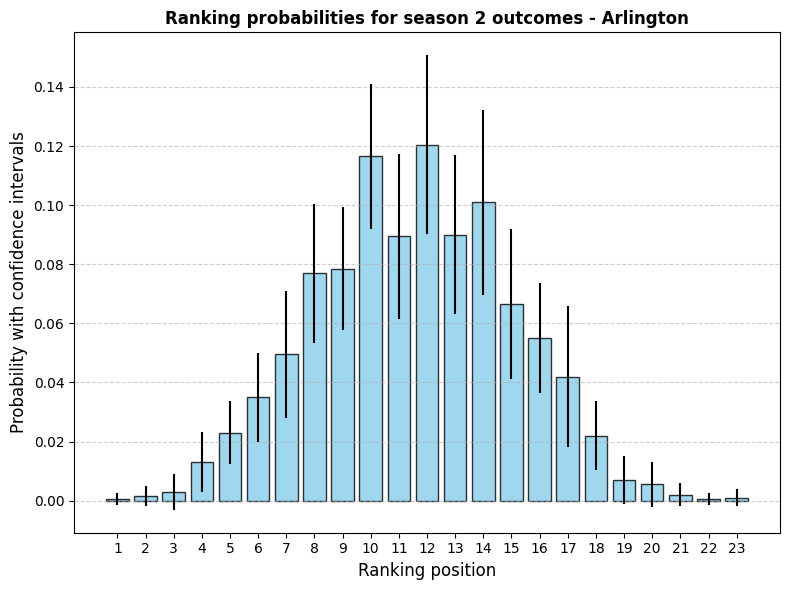

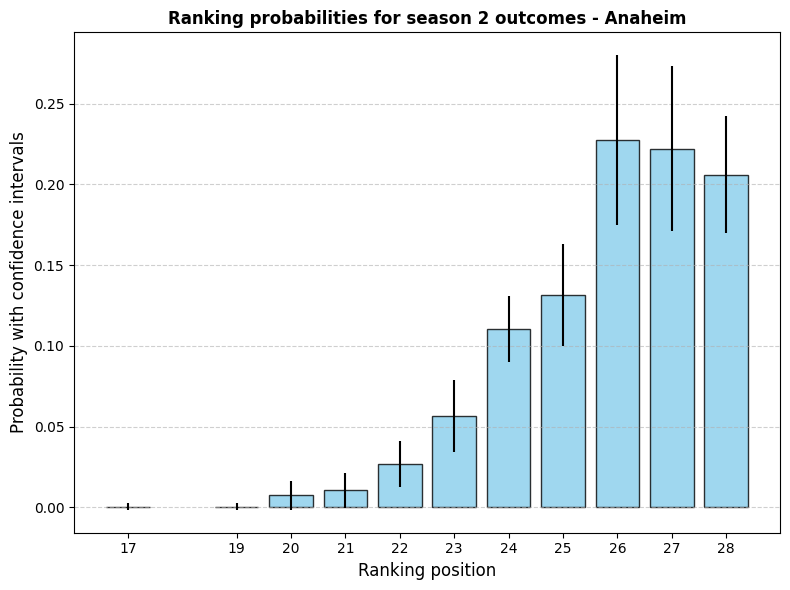

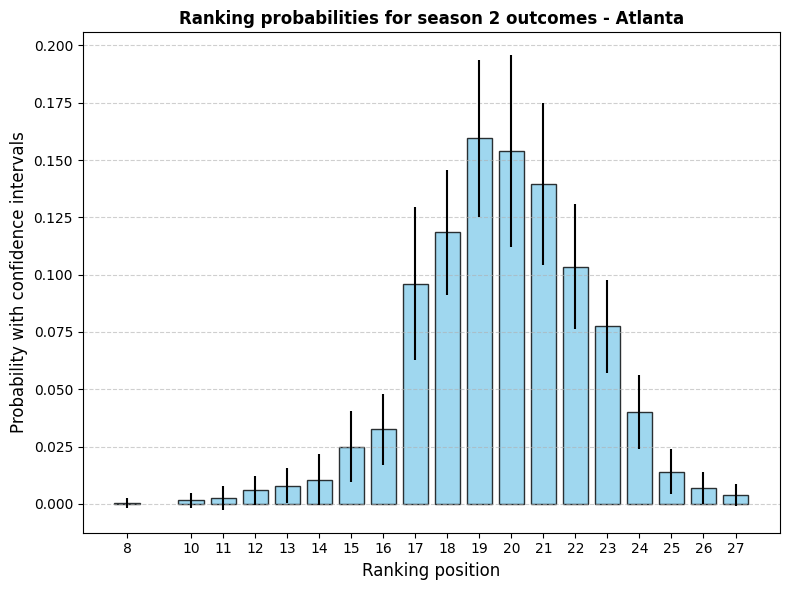

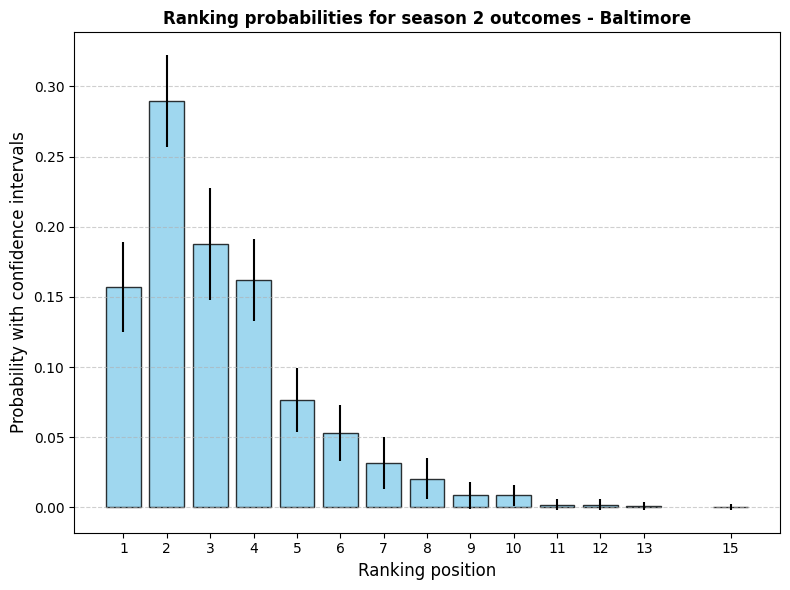

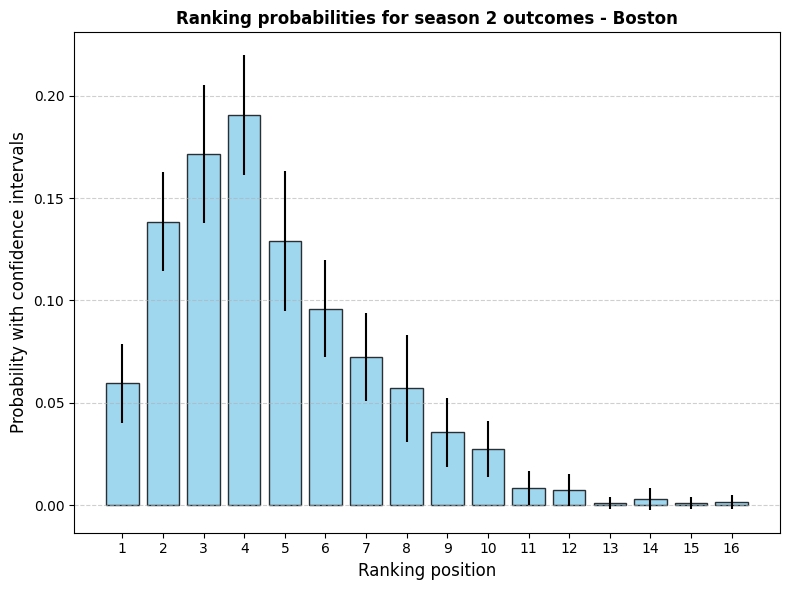

In [66]:
for i in ALL_TEAM_IDS:
    if i <= 5:
        team_name = teams_data[teams_data["TeamID"]==i]["TeamName"].values[0]
        ranking_team = df_ranking_season2_proba[f"TeamID_{i}"]
        confidence_intervals_values = df_CI_length[f"TeamID_{i}"]
        ranking_team_plot = ranking_team[ranking_team!=0]
        confidence_intervals_values_plot = confidence_intervals_values[ranking_team_plot.index]

        plt.figure(figsize = (8,6))
        plt.bar(ranking_team_plot.index, ranking_team_plot.values, yerr = confidence_intervals_values_plot.values, color='skyblue', edgecolor='black', alpha=0.8)
        plt.title(f"Ranking probabilities for season 2 outcomes - {team_name}", fontsize=12, fontweight='bold')
        plt.xticks(ranking_team_plot.index)
        plt.xlabel("Ranking position", fontsize=12)
        plt.ylabel("Probability with confidence intervals", fontsize=12)
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
    else:
        break

## Real ranking of season 2

We call the same functions used in the first notebook to generate the ranking of the season. 
These functions have been saved separetly in the utils.py file as we use them again but were left in the notebook so it is easier for ther reader to understand their purpose. 
 

If an error is returned when importing utils, please run in the terminal:

export PYTHONPATH=$PYTHONPATH:${PWD}

If it is still not working, the functions are commented in the cell below.

In [25]:
# def add_team_name(df : pd.DataFrame, teams_data : pd.DataFrame) -> pd.DataFrame:
#     """
#     Merge the results dataset with the team dataset to add the name of the playing teams for every fixture. 
#     """
#     df = df.merge(teams_data, left_on="HomeTeamID", right_on = "TeamID", how="left")\
#         .rename(columns = {"TeamName" : "HomeTeamName"})\
#             .drop(columns="TeamID")

#     return df.merge(teams_data, left_on="AwayTeamID", right_on = "TeamID", how="left")\
#         .rename(columns = {"TeamName" : "AwayTeamName"})\
#             .drop(columns="TeamID")


# def add_points(score_team1 : int, score_team2 : int) -> int:
#     """
#     Returns 3 points if Team 1 scored more goals than Team 2
#     1 point for a draw
#     0 points if Team 2 scored more goals than Team 1
#     """
#     if score_team1>score_team2:
#         return 3
#     elif score_team1<score_team2:
#         return 0
#     else:
#         return 1
    

# def melt_results_dataset(df : pd.DataFrame) -> pd.DataFrame:
#     """
#     Concatenate the points scored for home and away into a single column PointsScored for easier calculations later on.
#     """
#     df_team_home = pd.melt(df, id_vars = ["HomeTeamID", "HomeTeamName","Gameweek"], value_vars = ["HomePoints"], value_name="PointsScored")\
#     .rename(columns={"HomeTeamID":"TeamID", "HomeTeamName":"TeamName"})\
#     .drop(columns="variable")

#     df_team_away = pd.melt(df, id_vars = ["AwayTeamID", "AwayTeamName","Gameweek"], value_vars = ["AwayPoints"], value_name="PointsScored")\
#     .rename(columns={"AwayTeamID":"TeamID", "AwayTeamName":"TeamName"})\
#     .drop(columns="variable")

#     return pd.concat((df_team_home, df_team_away)).sort_values(["Gameweek", "TeamID"], axis = 0)


# def generate_final_ranking(df : pd.DataFrame) -> pd.DataFrame:
#     """
#     Generarte the final ranking of season by summing the total number of points scored by every team
#     throughout season 1. 
#     """
#     ## Aggregate per team and sum the total number of points scored by team
#     df_ranking_season = df.groupby(["TeamID", "TeamName"]).agg(
#         TotalPoints = ("PointsScored", "sum")
#     ).sort_values(by="TotalPoints", ascending=False).reset_index()

#     ## Creation of a ranking variable
#     df_ranking_season["Ranking"] = np.arange(1, len(df_ranking_season)+1)

#     return df_ranking_season

In [26]:
from project_code.utils import *

In [27]:
ground_truth_season2 = results_data_season2.copy()
ground_truth_season2 = add_team_name(ground_truth_season2, teams_data)
ground_truth_season2["HomePoints"] = ground_truth_season2.apply(lambda x: add_points(x.HomeScore, x.AwayScore), axis=1)
ground_truth_season2["AwayPoints"] = ground_truth_season2.apply(lambda x: add_points(x.AwayScore, x.HomeScore), axis=1)
df_all_team = melt_results_dataset(ground_truth_season2)
df_ranking_season2_gt = generate_final_ranking(df_all_team)
df_ranking_season2_gt

,TeamID,TeamName,TotalPoints,Ranking
0,15,Miami,133,1
1,19,New York S,126,2
2,4,Baltimore,114,3
3,5,Boston,112,4
4,8,Cincinnati,111,5
5,27,Seattle,110,6
6,6,Chicago B,107,7
7,24,St. Louis,91,8
8,1,Arlington,90,9
9,7,Chicago H,89,10


In [46]:
df_ranking_season2 = pd.DataFrame(df_ranking_season2_proba.idxmax(), columns = ["Season2Ranking"]).reset_index().rename(columns = {"index" : "TeamID"}).sort_values(by = ["Season2Ranking"])
df_ranking_season2 = df_ranking_season2[["Season2Ranking", "TeamID"]].reset_index(drop=True)
df_ranking_season2

,Season2Ranking,TeamID
0,1,TeamID_15
1,2,TeamID_4
2,3,TeamID_8
3,4,TeamID_5
4,5,TeamID_19
5,6,TeamID_24
6,6,TeamID_27
7,7,TeamID_6
8,9,TeamID_21
9,11,TeamID_22
